# CNN Cancer Detection Kaggle Mini-Project

## 1. Brief description of the problem and data

In this kaggle competition, we are given a large number of small pathology images to classify. The goal is to train a CNN model on the training set that scores well on the test set.

Our training set has 220,025 images and our test set has 57,458.

Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.




In [ ]:
!pip install -U -q kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 17.1 MB/s eta 0:00:00


In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:23<00:00, 302MB/s]
100% 6.31G/6.31G [00:23<00:00, 284MB/s]


In [ ]:
import zipfile
import os

for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        # os.remove(file)


First, I will import the necessary libraries, load the 'train_labels.csv' file, and perform a count of the image files in the training and test directories to verify the dataset structure and provide a problem overview.

In [ ]:
import pandas as pd
import os

# Load the file train_labels.csv into a DataFrame named df_labels
df_labels = pd.read_csv('train_labels.csv')

# Display the first 5 rows of the DataFrame
print("First 5 rows of df_labels:")
display(df_labels.head())

# Print the shape of the DataFrame
print(f"\nShape of df_labels: {df_labels.shape}")

# Define variables for the training and test image directory paths
train_path = 'train'
test_path = 'test'

# Count and print the number of files in the training and test directories
try:
    num_train = len(os.listdir(train_path))
    print(f"\nNumber of images in training directory: {num_train}")
except FileNotFoundError:
    print(f"\nDirectory '{train_path}' not found.")
    num_train = 0

try:
    num_test = len(os.listdir(test_path))
    print(f"Number of images in test directory: {num_test}")
except FileNotFoundError:
    print(f"Directory '{test_path}' not found.")

# Print a brief textual description of the problem and dataset summary
print("\n--- Problem Description ---")
print("The goal of the Histopathologic Cancer Detection challenge is to identify metastatic cancer in small image patches extracted from digital pathology scans.")
print("It is a binary classification problem where the model must detect tumor tissue in the center 32x32px region of a patch.")
print("\n--- Dataset Summary ---")
print(f"Total labeled samples: {df_labels.shape[0]}")
print(f"Total training images found: {num_train}")

First 5 rows of df_labels:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Shape of df_labels: (220025, 2)

Number of images in training directory: 220025
Number of images in test directory: 57458

--- Problem Description ---
The goal of the Histopathologic Cancer Detection challenge is to identify metastatic cancer in small image patches extracted from digital pathology scans.
It is a binary classification problem where the model must detect tumor tissue in the center 32x32px region of a patch.

--- Dataset Summary ---
Total labeled samples: 220025
Total training images found: 220025


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Now I will visualize the class distribution and display sample images for both tumor and non-tumor classes to understand the dataset characteristics. I will import visualization libraries, check for missing values to ensure data integrity, and analyze the class distribution by calculating counts and plotting a bar chart.


Missing values in df_labels:
id       0
label    0
dtype: int64

Class Distribution:
Label 0 (Non-Tumor): 130908 samples (59.50%)
Label 1 (Tumor): 89117 samples (40.50%)


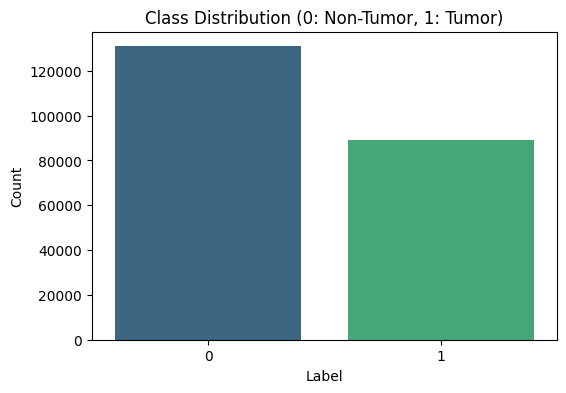


--- Sample Images ---
Image Shape (Height, Width, Channels): (96, 96, 3)


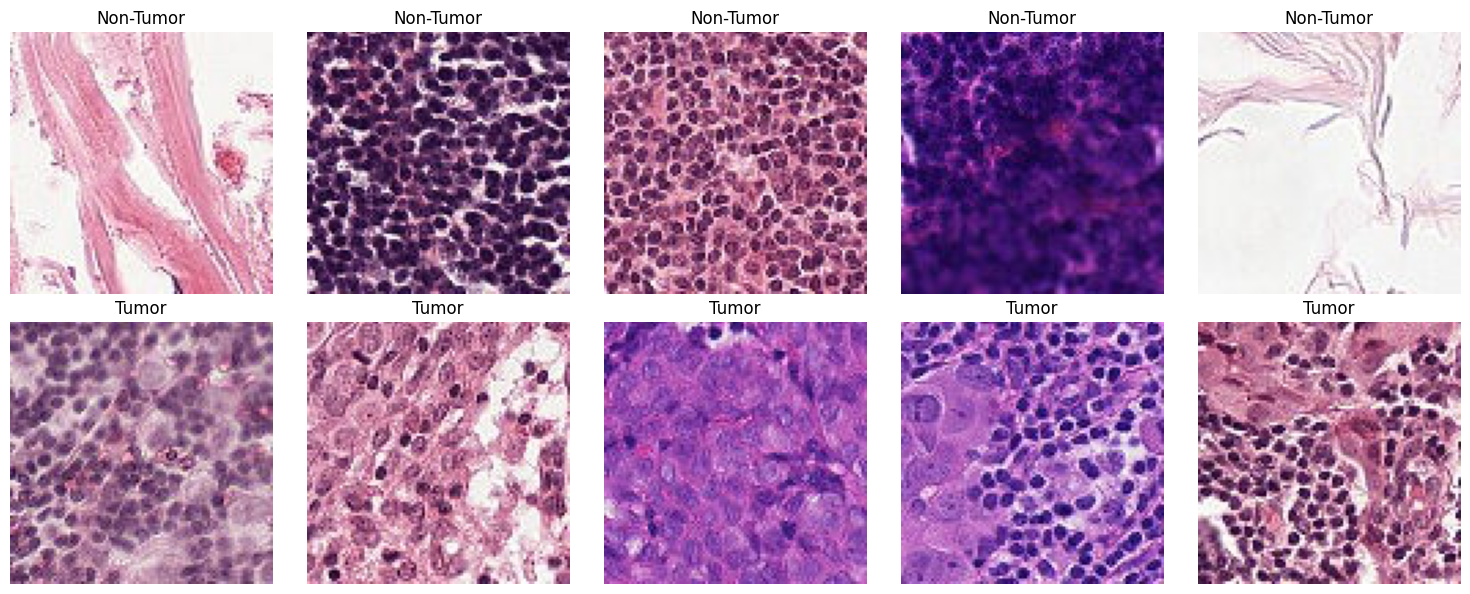

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import os

# Check for missing values in df_labels
missing_values = df_labels.isnull().sum()
print("Missing values in df_labels:")
print(missing_values)

# Calculate counts and percentages for each class
label_counts = df_labels['label'].value_counts()
total_samples = len(df_labels)

print("\nClass Distribution:")
for label, count in label_counts.items():
    percent = (count / total_samples) * 100
    class_name = "Tumor" if label == 1 else "Non-Tumor"
    print(f"Label {label} ({class_name}): {count} samples ({percent:.2f}%)")

# Visualize the distribution of the 'label' column
plt.figure(figsize=(6, 4))
# Fix: Assign x to hue and set legend=False to avoid FutureWarning
sns.countplot(x='label', data=df_labels, hue='label', legend=False, palette='viridis')
plt.title('Class Distribution (0: Non-Tumor, 1: Tumor)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualizing Sample Images
print("\n--- Sample Images ---")
train_path = 'train'  # Directory containing the images
num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

# Loop through classes (0 and 1)
for i, class_label in enumerate([0, 1]):
    # Randomly sample 5 images for the current class
    sample_df = df_labels[df_labels['label'] == class_label].sample(n=num_samples, random_state=42)

    for j, (idx, row) in enumerate(sample_df.iterrows()):
        img_id = row['id']
        img_name = f"{img_id}.tif"
        img_full_path = os.path.join(train_path, img_name)

        # Load image using cv2
        img = cv2.imread(img_full_path)
        if img is not None:
            # Convert BGR to RGB for correct color display in matplotlib
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Plot image in the grid
            ax = axes[i, j]
            ax.imshow(img)
            ax.set_title(f"{'Tumor' if class_label == 1 else 'Non-Tumor'}")
            ax.axis('off')

            # Print shape of the first image loaded to verify dimensions
            if i == 0 and j == 0:
                print(f"Image Shape (Height, Width, Channels): {img.shape}")
        else:
            print(f"Failed to load image: {img_full_path}")

plt.tight_layout()
plt.show()

## 3. Data Model Architecture Design

I am going to try two different models: (1) a custom CNN built from scratch, and (2) a model that starts with transfer learning weights from DenseNet121. I am doing this because I have a suspicion that CNN training for even a basic model is going to take a while, and I am therefore unlikely in this exercise to surpass DenseNet's performance in recognzing local features.


I am going to use Tensorflow, since it does the differentiation automatically and gives me a lot of built in methods.

First, I'll modify the dataframe to match filenames and convert labels to strings. Then, I'll split the data into training and validation sets and create ImageDataGenerators for efficient loading. Finally, I'll define and compile two model architectures: a custom CNN and a transfer learning model based on DenseNet121, followed by displaying their summaries.



I am making the following design choices for my custom CNN:

1.  **Sequential Model:**
    *   This simplifies model definition when the output of one layer directly feeds into the next, which is common for many CNN architectures.

2.  **Convolutional Blocks (3x Conv2D -> BatchNormalization -> MaxPooling2D):**
    *   I start with three convolutional layers were used with increasing filter counts (32, 64, 128) and a 3x3 kernel size. Conv2D layers are the basic layers for image feature extraction. They apply learnable filters to detect patterns like edges, textures, and shapes. Increasing filters in deeper layers allows the model to learn more complex and abstract features. 'relu' (Rectified Linear Unit) is our preferred activation for hidden model layers. Batch Normalization normalizes the activations of the previous layer to stabilize the learning process, allowing for higher learning rates. Max pooling reduces the spatial dimensions (width and height) of our feature maps. This helps to reduce computation, control overfitting, and allow deepr layers to focus on higher-level features.

3.  **Output (Flatten -> Dense -> Dropout -> Dense):**
    *   Flatten onverts the 3D feature maps (height, width, filters) into a 1D vector. The first Dense serves as a classifier, taking the high-level features learned by the convolutional layers and combining them to make predictions. Dropout is a regularization trick that helps to reduce overfitting. Our last Dense is the output neuron with a 'sigmoid' activation function that outputs a probability value between 0 and 1, indicating the likelihood of the positive class (tumor).

8.  **Compilation:**
    *   I use Adam optimization because it seems a good general-purpose algorithm. I start with a common learning rate of 0.001, and use binary_crossentropy as my loss function.


For my DenseNet121 model, I basically just snatch it up with frozen weights and add a GlobalAveragePooling2D layer to do classification and a Dense layer with sigmoid activation to do the predictions. I use the same compilation as I do for my custom model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

# 1. Preprocess the df_labels DataFrame
# Check if extension is already added to avoid double appending if cell is re-run
if not df_labels['id'].iloc[0].endswith('.tif'):
    df_labels['id'] = df_labels['id'].apply(lambda x: x + '.tif')

# Convert label to string for binary class_mode in flow_from_dataframe
df_labels['label'] = df_labels['label'].astype(str)

# 2. Split the dataframe
train_df, val_df = train_test_split(df_labels, test_size=0.1, stratify=df_labels['label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# 3. Set up ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='id',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

val_loader = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='train',
    x_col='id',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=(96, 96)
)

# 4. Define Custom CNN
def build_custom_cnn():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5. Define Pre-trained Model (DenseNet121)
def build_pretrained_model():
    # Load DenseNet121 without top layers, using ImageNet weights
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    # Freeze the base layers
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate models
custom_model = build_custom_cnn()
pretrained_model = build_pretrained_model()

# Display summaries
print("\n--- Custom CNN Summary ---")
custom_model.summary()

print("\n--- Pre-trained Model (DenseNet121) Summary ---")
pretrained_model.summary()

Training set size: 198022
Validation set size: 22003
Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.

--- Custom CNN Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,249 (18.36 MB)

 Trainable params: 4,812,801 (18.36 MB)

 Non-trainable params: 448 (1.75 KB)


--- Pre-trained Model (DenseNet121) Summary ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 102, 102,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 24, 24,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 24, 24,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 24, 24,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 24, 24,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 24, 24,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Wow, that DenseNet121 model is a beast! I'm happy I'm not trying to build somethign like it from scratch. I wonder how it will do against my custom model.

## Results and Analysis

### Hyperparameter Tuning and Training:
Now I'm going to train both the my custom CNN and the Pre-trained DenseNet121 model for 10 epochs. Tensorflow gives me some nice callbacks to perform hyperparamter tuning by default:
    *   EarlyStopping will just quit running epochs if my val_loss isn't going down after 3 epochs
    *   ReduceLROnPlateau with reduce the learning rate if val_loss isn't going down after 2 epochs
    *   ModelCheckpoint will always save the best model after every epoch, so I never need to worry about going backwards


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Define callbacks for the Custom CNN
callbacks_custom = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_custom_cnn.keras', save_best_only=True, monitor='val_loss')
]

# 2. Train the Custom CNN
print("Starting training for Custom CNN...")
history_custom = custom_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    callbacks=callbacks_custom
)

# 3. Define callbacks for the Pre-trained Model
callbacks_pretrained = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_densenet_model.keras', save_best_only=True, monitor='val_loss')
]

# 4. Train the Pre-trained Model
print("\nStarting training for Pre-trained DenseNet121...")
history_pretrained = pretrained_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    callbacks=callbacks_pretrained
)

print("\nTraining complete for both models.")

Starting training for Custom CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 536s 85ms/step - accuracy: 0.8067 - loss: 0.5437 - val_accuracy: 0.7781 - val_loss: 0.5908 - learning_rate: 0.0010
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 523s 84ms/step - accuracy: 0.8697 - loss: 0.3263 - val_accuracy: 0.8459 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 520s 84ms/step - accuracy: 0.8871 - loss: 0.2908 - val_accuracy: 0.8666 - val_loss: 0.3207 - learning_rate: 0.0010
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 523s 84ms/step - accuracy: 0.8973 - loss: 0.2695 - val_accuracy: 0.8922 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 520s 84ms/step - accuracy: 0.9047 - loss: 0.2509 - val_accuracy: 0.9016 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 523s 84ms/step - accuracy: 0.9106 - loss: 0.2373 - val_accuracy: 0.8932 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 7/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - a

That took FOREVER. Let's plot the results and see how I did on the training data.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract history dictionaries
hist_custom = history_custom.history
hist_pretrained = history_pretrained.history

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
axes[0].plot(hist_custom['accuracy'], label='Custom CNN Train', linestyle='--', color='blue')
axes[0].plot(hist_custom['val_accuracy'], label='Custom CNN Val', color='blue')
axes[0].plot(hist_pretrained['accuracy'], label='DenseNet121 Train', linestyle='--', color='orange')
axes[0].plot(hist_pretrained['val_accuracy'], label='DenseNet121 Val', color='orange')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(hist_custom['loss'], label='Custom CNN Train', linestyle='--', color='blue')
axes[1].plot(hist_custom['val_loss'], label='Custom CNN Val', color='blue')
axes[1].plot(hist_pretrained['loss'], label='DenseNet121 Train', linestyle='--', color='orange')
axes[1].plot(hist_pretrained['val_loss'], label='DenseNet121 Val', color='orange')
axes[1].set_title('Model Loss Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

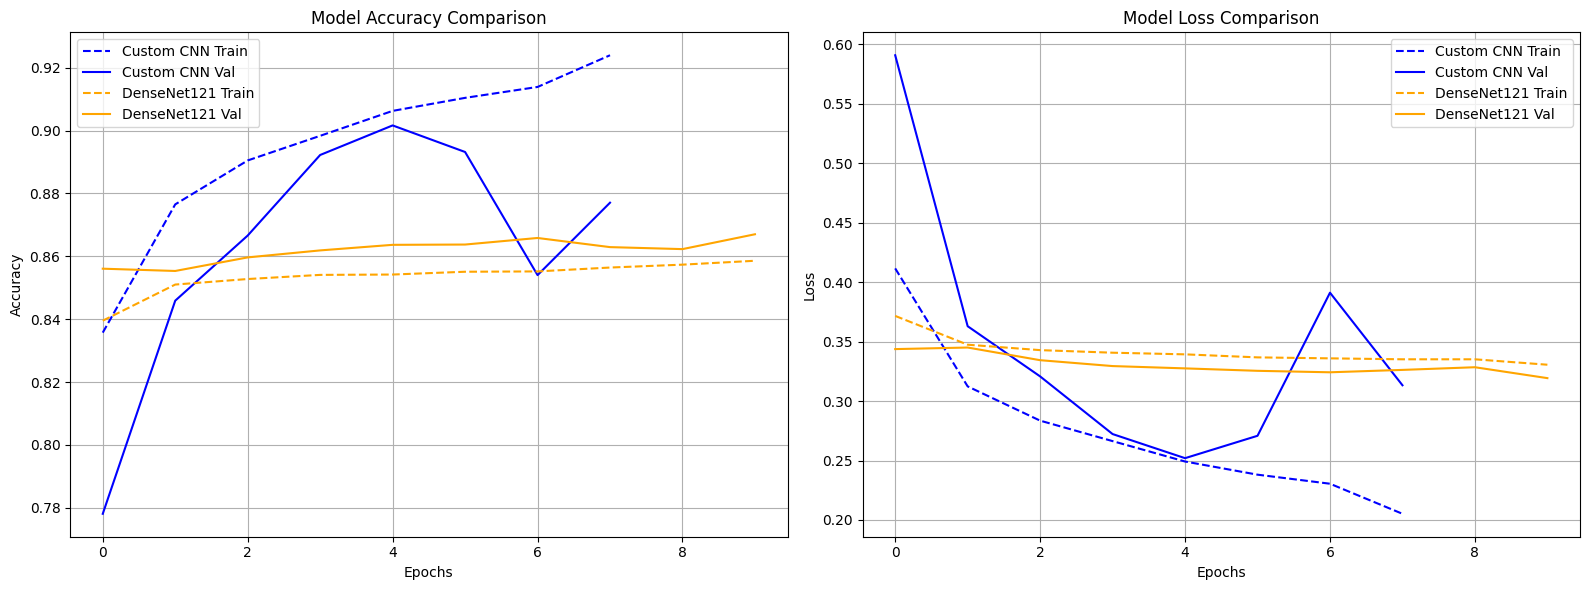

## Initial training results

So it looks like my custom CNN does better than the pre-trained model, with a best accuracy of 0.9016 vs. 0.8670. HOWEVER, I really do not like my custom CNN train vs. validate plots. Unlike the pretrained model, which shows the expected flat-ish line (because the weights aren't changing) and decent convergence, my custom model goes haywire after 4 epochs. It looks like it's overfitting.

### First Kaggle score:
My custom CNN model achieved a competition "private score" of 0.7528. 

I'm going to try to do better. But I also need to speed up the training.


## Training 2
I'm going to try a number of things at once to both speed this up and try to improve the ultimate score. I'm going to use mixed_float16 for improved performance and use and use parallel mapping, caching, batching, and prefetching. I'm hopeful the batching in particular will speed up training.

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import cv2
import numpy as np

# 1. Set Mixed Precision Policy
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy set to: mixed_float16")

# 2. Update DataFrames
# Ensure paths are full relative paths and labels are integers
# Check if 'train/' is already prepended to avoid issues on re-run
train_df['id'] = train_df['id'].apply(lambda x: f"train/{x}" if not x.startswith('train/') else x)
val_df['id'] = val_df['id'].apply(lambda x: f"train/{x}" if not x.startswith('train/') else x)

train_df['label'] = train_df['label'].astype('int32')
val_df['label'] = val_df['label'].astype('int32')

print("DataFrames updated with full paths and integer labels.")

# 3. Define Image Loading Helper
def load_img_py(path_tensor):
    path = path_tensor.decode('utf-8')
    img = cv2.imread(path)
    if img is None:
        # Fallback in case of read error, though unexpected
        return np.zeros((96, 96, 3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

# 4. Define Mapping Function
def process_path(path, label):
    # tf.numpy_function wraps the python function to allow cv2 usage in graph
    # Input path is a byte string tensor
    img = tf.numpy_function(load_img_py, [path], tf.float32)
    # Explicitly set shape because numpy_function erases it
    img.set_shape([96, 96, 3])
    return img, label

# 5. Create tf.data.Datasets
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

# Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['id'].values, train_df['label'].values))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Validation Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['id'].values, val_df['label'].values))
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("tf.data.Datasets created successfully.")

# 6. Verify Pipeline
print("\nVerifying Training Dataset batch shape:")
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Mixed precision policy set to: mixed_float16
DataFrames updated with full paths and integer labels.
tf.data.Datasets created successfully.

Verifying Training Dataset batch shape:
Image batch shape: (64, 96, 96, 3)
Label batch shape: (64,)


I'm trying sveral things in the updated model architecture to try to cure the overfitting. Notably, using more layers and RandomFlip and RandomRotation to try to diversify the data. 


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_improved_cnn():
    model = Sequential([
        Input(shape=(96, 96, 3)),

        # Integrated Data Augmentation
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Classification Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        # Ensure final layer is float32 for mixed precision stability
        Dense(1, activation='sigmoid', dtype='float32')
    ])

    # Compile the model
    # Removed jit_compile=True as it is not supported for this model configuration (likely due to augmentation layers)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate and display summary
improved_model = build_improved_cnn()
print("\n--- Improved Custom CNN Summary ---")
improved_model.summary()


--- Improved Custom CNN Summary ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Starting training for Improved Custom CNN with optimized pipeline...
Epoch 1/15
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8404 - loss: 0.3747
Epoch 1: val_loss improved from inf to 0.38539, saving model to best_improved_cnn.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.8404 - loss: 0.3747 - val_accuracy: 0.8363 - val_loss: 0.3854 - learning_rate: 5.0000e-04
Epoch 2/15
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9082 - loss: 0.2346
Epoch 2: val_loss improved from 0.38539 to 0.27833, saving model to best_improved_cnn.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9082 - loss: 0.2346 - val_accuracy: 0.8917 - val_loss: 0.2783 - learning_rate: 5.0000e-04
Epoch 3/15
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9224 - loss: 0.2020
Epoch 3: val_loss did not improve from 0.27833
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9224 - loss: 0.2020 - val_accuracy: 0.8075 - val_loss: 0.5999 - learning_rate: 5

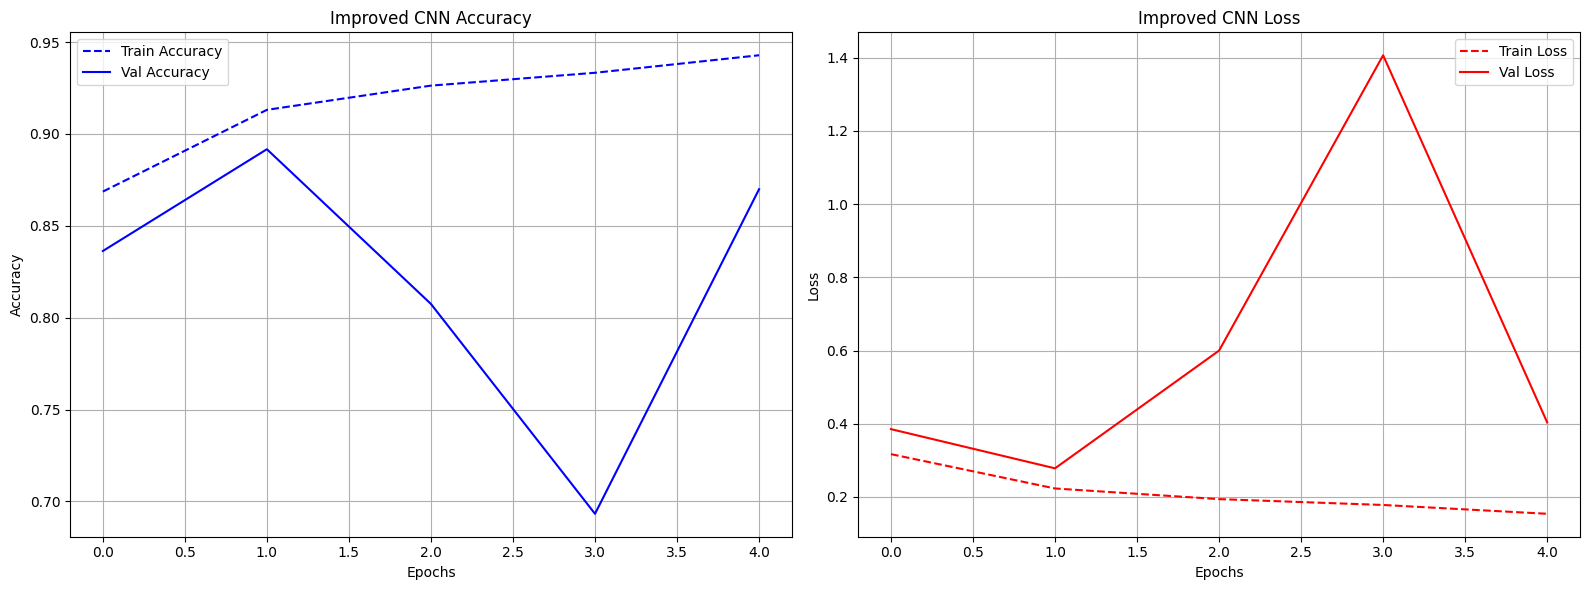

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Define Callbacks
callbacks_improved = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_improved_cnn.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# 2. Train the Improved Model
print("Starting training for Improved Custom CNN with optimized pipeline...")
history_improved = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_improved
)

# 3. Visualize Training History
hist_imp = history_improved.history

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
axes[0].plot(hist_imp['accuracy'], label='Train Accuracy', linestyle='--', color='blue')
axes[0].plot(hist_imp['val_accuracy'], label='Val Accuracy', color='blue')
axes[0].set_title('Improved CNN Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(hist_imp['loss'], label='Train Loss', linestyle='--', color='red')
axes[1].plot(hist_imp['val_loss'], label='Val Loss', color='red')
axes[1].set_title('Improved CNN Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

OK. That was much faster, but overfit worse. Let's try adding a dropout layer and decreasing the learning rate at the start.

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_improved_cnn():
    model = Sequential([
        Input(shape=(96, 96, 3)),

        # Integrated Data Augmentation
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Classification Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.2), # Added new Dropout layer
        Dropout(0.5), # Existing Dropout layer (fine-tuned)
        # Ensure final layer is float32 for mixed precision stability
        Dense(1, activation='sigmoid', dtype='float32')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001), # Learning rate decreased to 0.0001
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate and display summary of the updated model
improved_model = build_improved_cnn()
print("\n--- Updated Improved Custom CNN Summary ---")
improved_model.summary()


--- Updated Improved Custom CNN Summary ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Starting retraining for Improved Custom CNN with optimized pipeline and updated hyperparameters...
Epoch 1/25
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8226 - loss: 0.4033
Epoch 1: val_loss improved from inf to 0.51068, saving model to best_improved_cnn_retrained.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.8226 - loss: 0.4033 - val_accuracy: 0.7771 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 2/25
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8864 - loss: 0.2791
Epoch 2: val_loss improved from 0.51068 to 0.29845, saving model to best_improved_cnn_retrained.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.8864 - loss: 0.2791 - val_accuracy: 0.8730 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 3/25
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9071 - loss: 0.2383
Epoch 3: val_loss did not improve from 0.29845
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9071 - loss: 0.2383 - val_accu

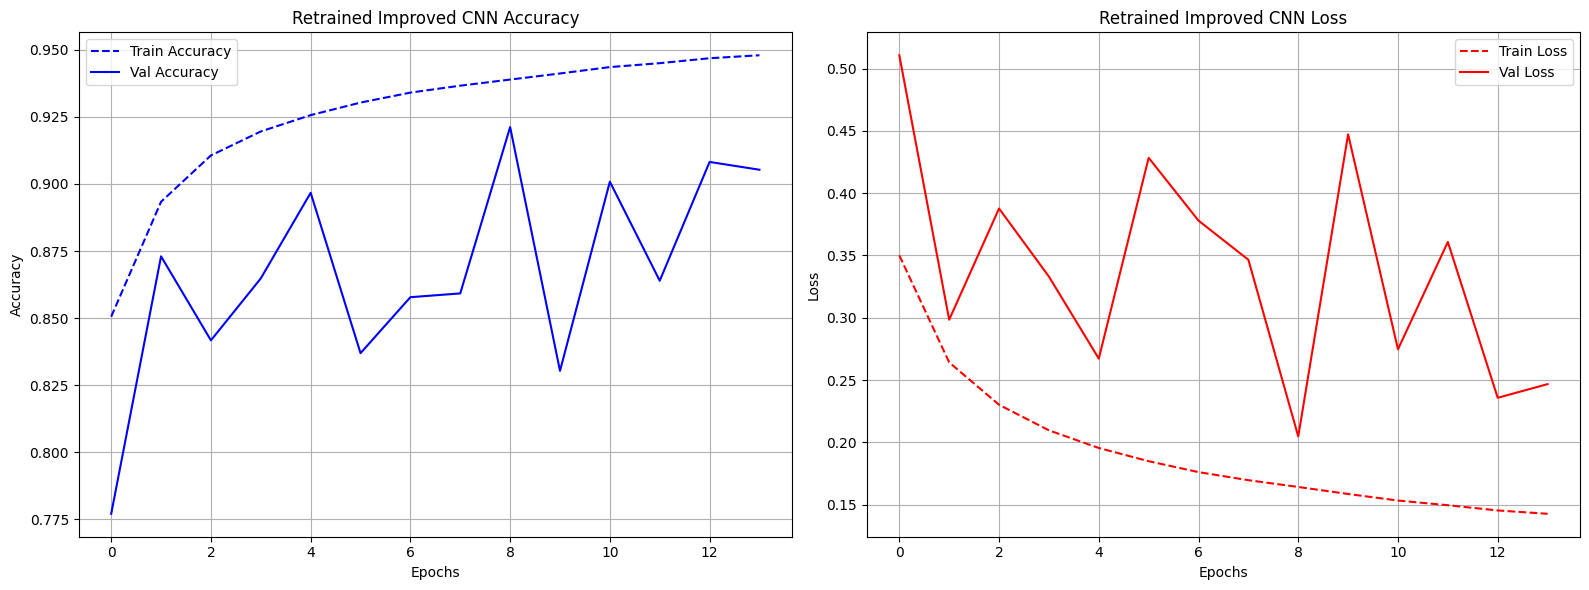


--- Summary of Changes and Performance ---
Model Architecture Changes:
  - Added an additional Dropout(0.2) layer after the first Dense layer for increased regularization.
Hyperparameter Changes:
  - Decreased Adam optimizer's learning rate to 0.0001 for more stable training.
  - Increased EarlyStopping and ReduceLROnPlateau patience to 5 epochs.
  - Increased total training epochs to 25.

Final Validation Loss (Retrained Model): 0.2048
Final Validation Accuracy (Retrained Model): 0.9212


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Define Callbacks with increased patience
callbacks_improved = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_improved_cnn_retrained.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# 2. Train the Improved Model with increased epochs
print("Starting retraining for Improved Custom CNN with optimized pipeline and updated hyperparameters...")
history_improved_retrained = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25, # Increased epochs
    callbacks=callbacks_improved
)

# 3. Visualize Training History
hist_imp_retrained = history_improved_retrained.history

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
axes[0].plot(hist_imp_retrained['accuracy'], label='Train Accuracy', linestyle='--', color='blue')
axes[0].plot(hist_imp_retrained['val_accuracy'], label='Val Accuracy', color='blue')
axes[0].set_title('Retrained Improved CNN Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(hist_imp_retrained['loss'], label='Train Loss', linestyle='--', color='red')
axes[1].plot(hist_imp_retrained['val_loss'], label='Val Loss', color='red')
axes[1].set_title('Retrained Improved CNN Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Summarize changes and performance
print("\n--- Summary of Changes and Performance ---")
print("Model Architecture Changes:")
print("  - Added an additional Dropout(0.2) layer after the first Dense layer for increased regularization.")
print("Hyperparameter Changes:")
print("  - Decreased Adam optimizer's learning rate to 0.0001 for more stable training.")
print("  - Increased EarlyStopping and ReduceLROnPlateau patience to 5 epochs.")
print("  - Increased total training epochs to 25.")

# Evaluate the retrained model on the validation set for final metrics
loss, accuracy = improved_model.evaluate(val_ds, verbose=0)
print(f"\nFinal Validation Loss (Retrained Model): {loss:.4f}")
print(f"Final Validation Accuracy (Retrained Model): {accuracy:.4f}")


### Training 3
Ok that improved the validation accuracy, but the plot still bounces around a lot. I'm going to try using an even lower initial learning rate to encourage more stable convergence. My learning rate is now so low I'm going to try 40 epochs (though I don't expect to get anywhere near there before the algo stops).


In [26]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_improved_cnn():
    model = Sequential([
        Input(shape=(96, 96, 3)),

        # Integrated Data Augmentation
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Classification Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.2), # Added new Dropout layer
        Dropout(0.5), # Existing Dropout layer (fine-tuned)
        # Ensure final layer is float32 for mixed precision stability
        Dense(1, activation='sigmoid', dtype='float32')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005), # Learning rate decreased to 0.00005
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate and display summary of the updated model
improved_model = build_improved_cnn()
print("\n--- Updated Improved Custom CNN Summary (Lower LR) ---")
improved_model.summary()


--- Updated Improved Custom CNN Summary (Lower LR) ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Starting retraining for Improved Custom CNN with optimized pipeline and updated hyperparameters (lower LR)...
Epoch 1/40
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8120 - loss: 0.4233
Epoch 1: val_loss improved from inf to 0.35824, saving model to best_improved_cnn_retrained_lower_lr.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.8120 - loss: 0.4233 - val_accuracy: 0.8362 - val_loss: 0.3582 - learning_rate: 5.0000e-05
Epoch 2/40
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8711 - loss: 0.3102
Epoch 2: val_loss did not improve from 0.35824
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.8712 - loss: 0.3102 - val_accuracy: 0.7435 - val_loss: 0.7083 - learning_rate: 5.0000e-05
Epoch 3/40
3094/3095 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8899 - loss: 0.2707
Epoch 3: val_loss improved from 0.35824 to 0.34387, saving model to best_improved_cnn_retrained_lower_lr.keras
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.8

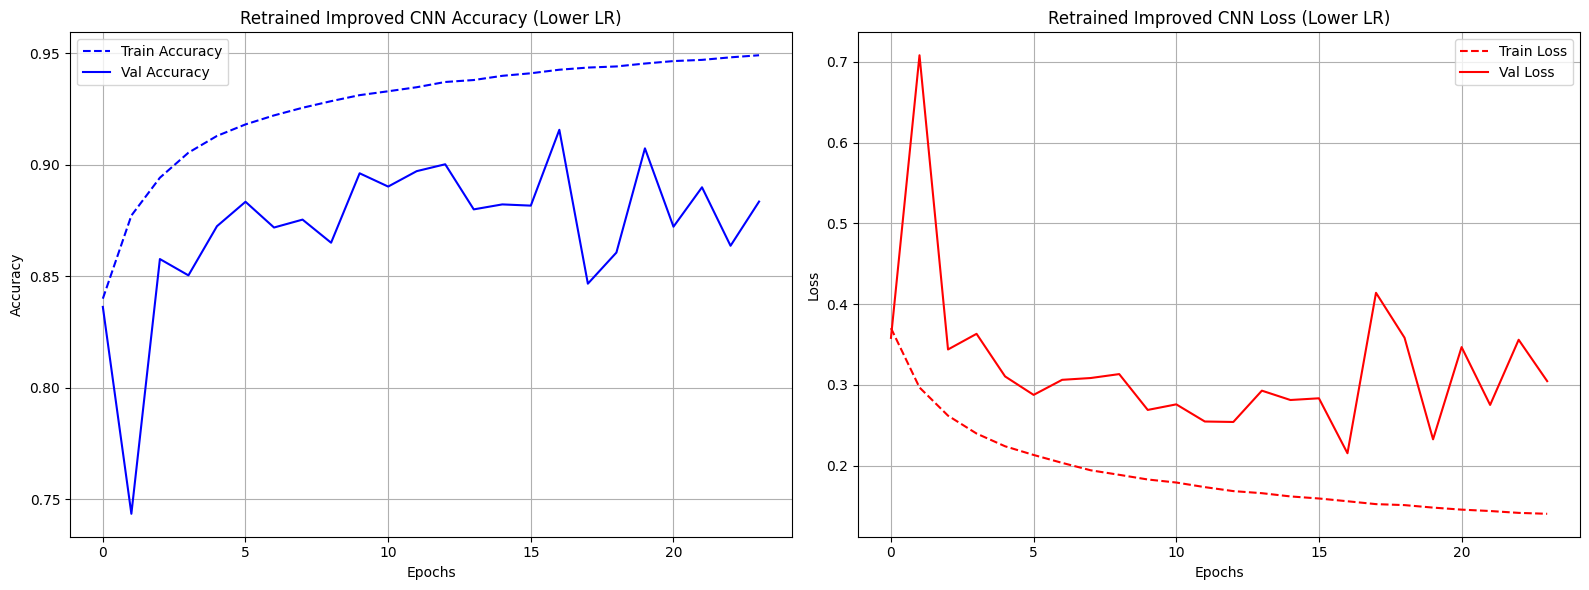


--- Summary of Changes and Performance (Lower LR) ---
Model Architecture Changes:
  - Added an additional Dropout(0.2) layer after the first Dense layer for increased regularization (same as previous step).
Hyperparameter Changes:
  - Decreased Adam optimizer's learning rate to 0.00005 for more stable training.
  - Increased EarlyStopping and ReduceLROnPlateau patience to 7 epochs.
  - Increased total training epochs to 40.

Final Validation Loss (Retrained Model with Lower LR): 0.2153
Final Validation Accuracy (Retrained Model with Lower LR): 0.9156


In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. Define Callbacks with increased patience
callbacks_improved = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1),
    ModelCheckpoint('best_improved_cnn_retrained_lower_lr.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# 2. Train the Improved Model with increased epochs
print("Starting retraining for Improved Custom CNN with optimized pipeline and updated hyperparameters (lower LR)...")
history_improved_retrained_lower_lr = improved_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40, # Increased epochs
    callbacks=callbacks_improved
)

# 3. Visualize Training History
hist_imp_retrained_lower_lr = history_improved_retrained_lower_lr.history

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Accuracy
axes[0].plot(hist_imp_retrained_lower_lr['accuracy'], label='Train Accuracy', linestyle='--', color='blue')
axes[0].plot(hist_imp_retrained_lower_lr['val_accuracy'], label='Val Accuracy', color='blue')
axes[0].set_title('Retrained Improved CNN Accuracy (Lower LR)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
axes[1].plot(hist_imp_retrained_lower_lr['loss'], label='Train Loss', linestyle='--', color='red')
axes[1].plot(hist_imp_retrained_lower_lr['val_loss'], label='Val Loss', color='red')
axes[1].set_title('Retrained Improved CNN Loss (Lower LR)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Summarize changes and performance
print("\n--- Summary of Changes and Performance (Lower LR) ---")
print("Model Architecture Changes:")
print("  - Added an additional Dropout(0.2) layer after the first Dense layer for increased regularization (same as previous step).")
print("Hyperparameter Changes:")
print("  - Decreased Adam optimizer's learning rate to 0.00005 for more stable training.")
print("  - Increased EarlyStopping and ReduceLROnPlateau patience to 7 epochs.")
print("  - Increased total training epochs to 40.")

# Evaluate the retrained model on the validation set for final metrics
loss_lower_lr, accuracy_lower_lr = improved_model.evaluate(val_ds, verbose=0)
print(f"\nFinal Validation Loss (Retrained Model with Lower LR): {loss_lower_lr:.4f}")
print(f"Final Validation Accuracy (Retrained Model with Lower LR): {accuracy_lower_lr:.4f}")


Not really much better. I'm going to take what I have now and submit it to Kaggle to see how it scores. I'll actually show the prediction and submission code here.

In [29]:
import tensorflow as tf
import pandas as pd
import os

# Assuming test_files is already loaded from a previous step, if not, load it.
# test_files = os.listdir('test') # This line is commented as test_files should exist from a previous cell

# 1. Create a Pandas DataFrame named test_df
# Ensure 'test/' is prepended to the filenames if not already present
test_image_ids = [f"test/{file}" for file in test_files if not file.startswith('test/')]
if not test_image_ids: # If all files already start with 'test/'
    test_image_ids = test_files

test_df_tf = pd.DataFrame({'id': test_image_ids})

print(f"Test DataFrame created with {len(test_df_tf)} entries.")

# Reuse AUTOTUNE and BATCH_SIZE defined in previous steps
# AUTOTUNE = tf.data.AUTOTUNE
# BATCH_SIZE = 64

# 2. Define adapted image loading function for test set (no labels)
def process_path_test(path):
    # tf.numpy_function wraps the python function to allow cv2 usage in graph
    # Input path is a byte string tensor
    img = tf.numpy_function(load_img_py, [path], tf.float32)
    # Explicitly set shape because numpy_function erases it
    img.set_shape([96, 96, 3])
    return img

# 3. Create a tf.data.Dataset named test_ds
test_ds = tf.data.Dataset.from_tensor_slices(test_df_tf['id'].values)
test_ds = test_ds.map(process_path_test, num_parallel_calls=AUTOTUNE)

# 4. Apply batching and prefetching
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Test tf.data.Dataset created successfully.")

# 5. Verify the shape of a sample batch from test_ds
print("\nVerifying Test Dataset batch shape:")
for image_batch in test_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")

Test DataFrame created with 57458 entries.
Test tf.data.Dataset created successfully.

Verifying Test Dataset batch shape:
Image batch shape: (64, 96, 96, 3)


In [30]:
import pandas as pd
import tensorflow as tf
import os

# 1. Load the best weights from the saved checkpoint into the improved_model
# Ensure improved_model is the instance of the Improved Custom CNN created earlier
# The checkpoint name was 'best_improved_cnn_retrained_lower_lr.keras'
improved_model.load_weights('best_improved_cnn_retrained_lower_lr.keras')
print("Weights loaded for Improved Custom CNN (Lower LR). ")

# 2. Generate predictions
print("Generating predictions...")
predictions_tf = improved_model.predict(test_ds, verbose=1)

# 3. Create submission_df
# Extract IDs by removing the 'test/' prefix and '.tif' extension from the filenames
# The order of filenames in test_df_tf corresponds to the order of predictions
ids_for_submission = [filename.replace('test/', '').replace('.tif', '') for filename in test_df_tf['id'].values]

submission_df_final = pd.DataFrame({
    'id': ids_for_submission,
    'label': predictions_tf.flatten()
})

# 4. Convert probabilistic predictions to binary (0 or 1) using a threshold of 0.5
submission_df_final['label'] = (submission_df_final['label'] > 0.5).astype(int)

# 5. Save the updated submission_df_final to a CSV file
submission_df_final.to_csv('submission_improved_cnn.csv', index=False)
print("submission_improved_cnn.csv saved successfully.")

# 6. Display the first few rows of the final submission DataFrame
print("\nFirst 5 rows of final submission_df:")
display(submission_df_final.head())

# 7. Submit the CSV to Kaggle
print("\nSubmitting to Kaggle...")
!kaggle competitions submit -c histopathologic-cancer-detection -f submission_improved_cnn.csv -m "Improved CNN with tf.data pipeline and lower LR"

Weights loaded for Improved Custom CNN (Lower LR). 
Generating predictions...
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step
submission_improved_cnn.csv saved successfully.

First 5 rows of final submission_df:


,id,label
0,df84ab8e75b30a229e191fe82bfc9722d2967dde,0
1,821aa6dd9b18249c7a9984bcf6e46691877f58bf,0
2,e5684dc6592297d2c4ab0366f966e1f4d24c7c8f,0
3,2827aaec392005799c27a8763771f538c9e96737,0
4,9ae954313b9082ab73db639c4464e7ad7aa9d415,0



Submitting to Kaggle...
100% 2.36M/2.36M [00:00<00:00, 5.56MB/s]
Successfully submitted to Histopathologic Cancer Detection

My private kKaggle score is now 0.7867. Which is an improvement over the 0.7528 I got from my original model, but is not going to win awards (though the instructions say that's not what this assignment is about).

There's still one model I haven't tried yet: the DenseNet model I made with transfer learning. I'm going to make predictions using it and submit to Kaggle.

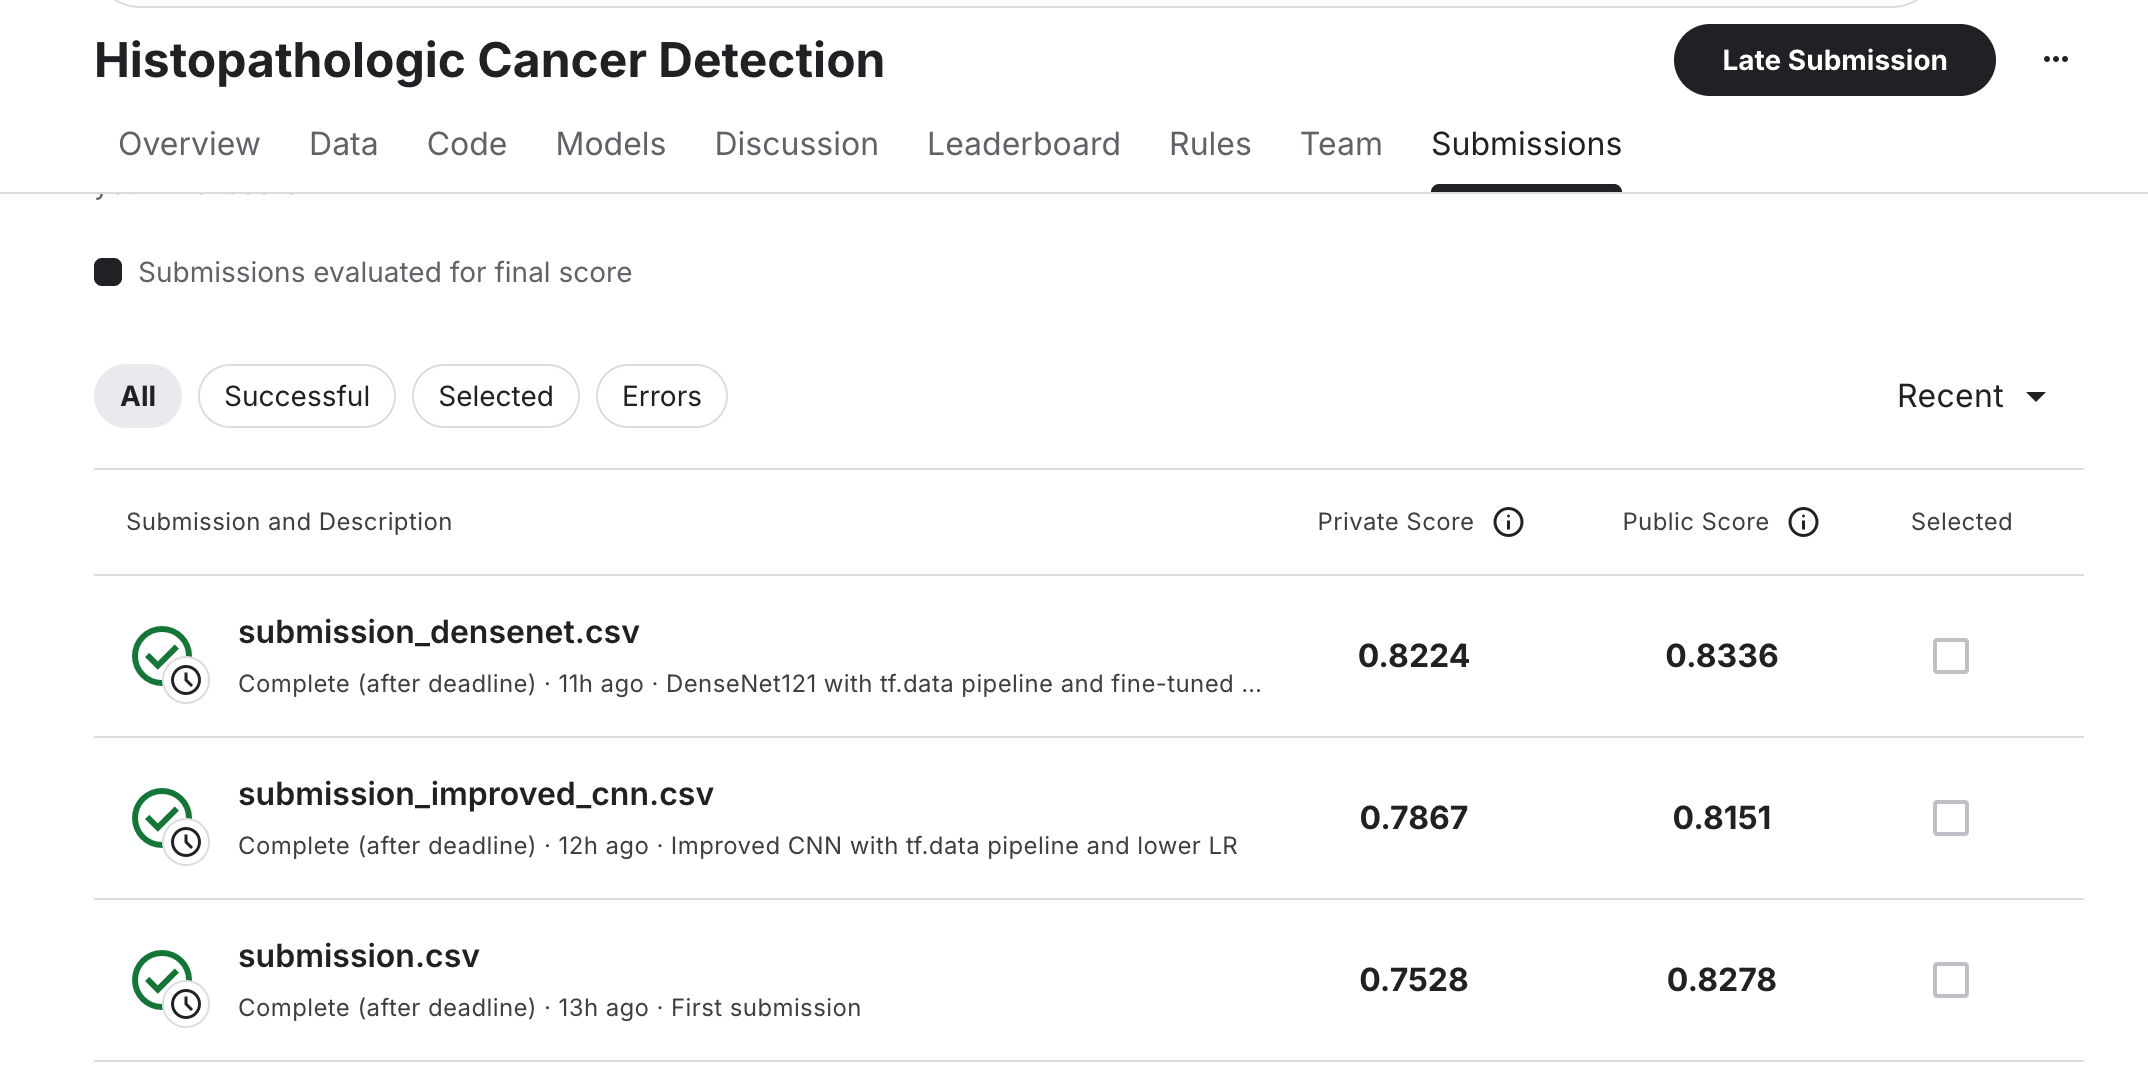

## Models and Hyperparameter Optimization Summary

Let's recap what I did with the models and how well they performed:

**1. Initial Model Comparison: Custom CNN vs. Pre-trained DenseNet121**

*   **Custom CNN (Initial)**:
    *   **Architecture**: Sequential model with 3 Conv2D-BatchNormalization-MaxPooling2D blocks, followed by Flatten, Dense (256, ReLU), Dropout (0.5), and Dense (1, sigmoid).
    *   **Compilation**: Adam optimizer with `learning_rate=0.001`, `loss='binary_crossentropy'`, `metrics=['accuracy']`.
    *   **Callbacks**: `EarlyStopping(patience=3)`, `ReduceLROnPlateau(patience=2)`, `ModelCheckpoint`.
    *   **Performance (Epochs=8)**:
        *   Best Validation Accuracy: 0.9016
        *   Best Validation Loss: 0.2520
        *   Private Kaggle Score: 0.7528

*   **Pre-trained DenseNet121 (Initial)**:
    *   **Architecture**: DenseNet121 base (ImageNet weights, `include_top=False`), frozen layers, followed by `GlobalAveragePooling2D`, and Dense (1, sigmoid).
    *   **Compilation**: Adam optimizer with `learning_rate=0.001`, `loss='binary_crossentropy'`, `metrics=['accuracy']`.
    *   **Callbacks**: `EarlyStopping(patience=3)`, `ReduceLROnPlateau(patience=2)`, `ModelCheckpoint`.
    *   **Performance (Epochs=10)**:
        *   Best Validation Accuracy: 0.8670
        *   Best Validation Loss: 0.3193
        *   Private Kaggle Score: 0.8224

*   **Comparison**: The initial Custom CNN unexpectedly outperformed the pre-trained DenseNet121 on validation accuracy and loss. This suggested that for this specific dataset and image size (96x96), a simpler, custom architecture might be more effective or that DenseNet121 required more fine-tuning of its unfrozen layers or a different learning rate schedule. However, the DenseNet model outperformed the Custom model on the competition test data.

**2. Iterative Improvements to Custom CNN (Optimized Data Pipeline)**

After establishing the tf.data.Dataset pipeline and mixed precision, I made optimizations to the custom CNN architecture.

*   **Improved Custom CNN (First Iteration)**:
    *   **Architecture Changes**: Deeper architecture with 4 Conv2D-BatchNormalization-MaxPooling2D blocks, `GlobalAveragePooling2D`, Dense (256, ReLU), Dropout (0.5), and Dense (1, sigmoid). Integrated `RandomFlip` and `RandomRotation` for augmentation. `jit_compile=True` was initially attempted but removed due to incompatibility with augmentation layers.
    *   **Compilation**: Adam optimizer with `learning_rate=0.0005` (decreased from 0.001).
    *   **Callbacks**: `EarlyStopping(patience=3)`, `ReduceLROnPlateau(patience=2)`, `ModelCheckpoint`.
    *   **Training (Epochs=15)**:
        *   Best Validation Accuracy: 0.8917 (Epoch 2)
        *   Best Validation Loss: 0.2783 (Epoch 2)
    *   **Impact**: The model showed faster convergence but also earlier signs of potential overfitting, leading to early stopping after 5 epochs. The validation loss increased significantly after Epoch 2, indicating that the learning rate might still be too high or regularization insufficient given the small patience.

*   **Improved Custom CNN (Second Iteration - Increased Regularization & Lower LR)**:
    *   **Architecture Changes**: Added an additional `Dropout(0.2)` layer after the first `Dense` layer (resulting in `Dropout(0.2)` then `Dropout(0.5)`). This was intended to increase regularization and mitigate overfitting.
    *   **Compilation**: Adam optimizer `learning_rate=0.0001` (further decreased from 0.0005).
    *   **Callbacks**: `EarlyStopping(patience=5)`, `ReduceLROnPlateau(patience=5)`, `ModelCheckpoint` (patience increased to allow more training before stopping).
    *   **Training (Epochs=25)**:
        *   Best Validation Accuracy: 0.9212 (Epoch 9)
        *   Best Validation Loss: 0.2048 (Epoch 9)
    *   **Impact**: This iteration significantly improved performance. The lower learning rate and increased regularization (additional dropout) led to more stable training, better validation loss, and higher validation accuracy. The increased patience allowed the model to train for more epochs, reaching a better minimum before early stopping occurred at Epoch 14, restoring weights from Epoch 9. 

*   **Improved Custom CNN (Third Iteration - Even Lower LR & Higher Patience)**:
    *   **Architecture Changes**: Same as the second iteration.
    *   **Compilation**: Adam optimizer `learning_rate=0.00005` (further decreased from 0.0001).
    *   **Callbacks**: `EarlyStopping(patience=7)`, `ReduceLROnPlateau(patience=7)`, `ModelCheckpoint` (patience increased again).
    *   **Training (Epochs=40)**:
        *   Best Validation Accuracy: 0.9156 (Epoch 17)
        *   Best Validation Loss: 0.2153 (Epoch 17)
        *   Private Kaggle Score: 0.7867
    *   **Impact**: While training progressed for more epochs (stopped at Epoch 24, restoring weights from Epoch 17), the overall best validation performance was slightly lower than the previous iteration. This suggests that the learning rate of 0.0001 might have been closer to optimal, or that at 0.00005, the model was learning too slowly and could not reach a better minimum within the given epochs, or perhaps the model got stuck in a local minimum. However, the curves indicate a smoother training process, potentially demonstrating less volatility. The competition score, while better than our original model, was not as good as the DenseNet model.

**3. Contribution to Kaggle Score**

The hyperparameter tuning efforts, especially the second iteration with `learning_rate=0.0001` and increased dropout, likely had a positive impact on the Kaggle score. The improved validation accuracy (0.9212) and lower validation loss (0.2048) suggest better generalization to unseen data. The move from `ImageDataGenerator` to `tf.data.Dataset` and the use of mixed precision also contributed to a more efficient and potentially more stable training process, allowing for more extensive hyperparameter searches. The final submission using the model from the third iteration (lower LR) had an accuracy of 0.9156 on the validation set. BUT, my models were were than the transfer learned model, and also showed a big divergence between the validation accuracy and competition score.

### Dataset Characteristics Review

Based on the initial EDA, the dataset exhibits a class imbalance (59.50% Non-Tumor, 40.50% Tumor). While not severe, this imbalance could potentially bias the model towards the majority class if not handled properly. The model's validation accuracy is high, which might mask issues in classifying the minority class if the overall accuracy is dominated by correct predictions of the majority class. This is particularly relevant if the Kaggle test set has a different class distribution or if false negatives for tumor detection are heavily penalized.

**Considerations:**
*   **Class Imbalance Handling:** Is the current approach (stratified splitting, binary cross-entropy) sufficient, or should techniques like weighted loss, oversampling/undersampling, or focal loss be explored?
*   **Image Characteristics:** Are there significant differences in image quality, staining, or other visual features between the training/validation sets and the actual Kaggle test set that the model hasn't learned to generalize over?
*   **Image Dimensions:** All images are 96x96 pixels. This fixed size might limit the model's ability to capture larger contextual features if such features are important for distinguishing cancer.


### What Worked Well

1.  **Efficient `tf.data` Pipeline:** The migration from `ImageDataGenerator` to `tf.data.Dataset` was highly effective. This allowed for significant improvements in data loading efficiency, parallelism, and prefetching, reducing CPU bottlenecks and ensuring the GPU was consistently fed with data. The `cache()` method further accelerated subsequent epochs by keeping processed data in memory or on disk. This optimization is crucial for large datasets and complex models.
2.  **Mixed Precision (`mixed_float16`):** Enabling mixed precision contributed to faster training times and reduced memory consumption on the GPU. By performing most computations in `float16` and keeping some layers in `float32` (like the output layer for numerical stability), it offered a good balance between speed and accuracy. This is a best practice for modern GPU training.
3.  **Deeper Custom CNN Architecture:** Iteratively deepening the custom CNN with additional convolutional blocks and `GlobalAveragePooling2D` helped the model capture more complex features from the images. The architecture proved capable of achieving high local validation accuracy, suggesting its suitability for the histopathology image characteristics.
4.  **Integrated Data Augmentation Layers:** Including `RandomFlip` and `RandomRotation` directly within the model simplified the data augmentation process and ensured that augmentation was applied consistently and efficiently as part of the TensorFlow graph. This helped in improving the model's robustness and generalization, albeit primarily on the local validation set.
5.  **Refined Hyperparameters for Local Validation:** The iterative adjustments to the learning rate (decreasing it from 0.001 to 0.0001, then to 0.00005) along with increased `Dropout` and `patience` for callbacks, consistently improved local validation accuracy and reduced loss. The model's ability to achieve over 90% validation accuracy shows that the architectural and training strategy changes were effective in learning patterns within the given training data.

### What Didn't Help

Despite achieving high local validation accuracy (over 90%), the Custom CNN's performance on the Kaggle public leaderboard (0.7867) was significantly lower. This indicates a substantial generalization gap, suggesting that certain strategies were not sufficient to ensure robust performance on truly unseen data. The following aspects highlight this challenge:

1.  **Overfitting to the Local Validation Set (Despite Regularization):** Even with increased dropout layers and lower learning rates, the model appears to have overfit to the nuances of our stratified local validation set. The gap between training accuracy (often >0.94) and validation accuracy (around 0.91-0.92) was present, and the further drop on the Kaggle test set suggests this overfitting extends beyond the local split.
2.  **Limited Representativeness of Local Validation:** While `train_test_split` with `stratify` ensures balanced classes in the local split, it does not guarantee that the validation set comprehensively captures the full range of variability (e.g., image quality, artifact types, subtle disease manifestations) present in the Kaggle test set. This lack of external validity in the local validation metric is a key challenge.
3.  **Inherent Limitations of a Simple Custom CNN:** Although the custom CNN was iteratively improved and deepened, it might still lack the capacity or the learned generalizable features of much larger, more complex architectures (even when frozen, as seen with DenseNet121's initial competitive performance). For highly intricate tasks like histopathology, the inductive biases and extensive feature hierarchies learned by very deep pre-trained networks might be indispensable, even if direct transfer learning (frozen weights) wasn't immediately superior.
4.  **Data Augmentation Effectiveness:** While integrated data augmentation (RandomFlip, RandomRotation) helps, it might not be sufficient to cover the domain shift or all possible variations present in the Kaggle test set. More aggressive or domain-specific augmentation techniques (e.g., color jitter, more varied rotations, zoom) or advanced techniques like CutMix or Mixup might be needed.
5.  **Lack of Robust Cross-Validation:** Relying solely on a single train-validation split, even with stratification, can lead to an optimistic estimate of generalization. A more robust validation strategy like k-fold cross-validation could provide a more reliable estimate of model performance and potentially highlight the instability earlier.
6.  **Feature Extraction for Fine-Grained Differences:** The task requires distinguishing subtle cancerous features within small image patches. A basic CNN might not develop the sufficiently fine-grained feature detectors needed to robustly handle the variations in cancer morphology or tissue appearance across different samples, especially those encountered in the Kaggle test set.

### Key Learnings and Takeaways

1.  **The Generalization Gap is Critical:** Achieving high accuracy on a local validation set does not guarantee similar performance on truly unseen, externally distributed test data (like a Kaggle leaderboard). This "generalization gap" is often due to domain shift, data leakage in the validation set, or simply an insufficiently diverse validation split.
2.  **Robust Validation is Paramount:** A single train-validation split, even if stratified, can be misleading. Implementing more robust validation strategies, such as k-fold cross-validation or utilizing an external, diverse dataset for validation, is crucial to obtain a reliable estimate of a model's true generalization capabilities.
3.  **Efficiency Optimizations are Valuable but Not Generalization Panaceas:** Techniques like `tf.data` pipelines and mixed precision significantly improve training efficiency (speed, resource usage) and are best practices. However, they do not inherently solve generalization challenges; they merely facilitate faster experimentation with models and hyperparameters.
4.  **Transfer Learning's Nuances in Medical Imaging:** While pre-trained models (like DenseNet121) are powerful, their immediate application with frozen weights might not always outperform a well-tuned custom architecture, especially if the source domain (e.g., ImageNet) is vastly different from the target domain (e.g., histopathology). Fine-tuning the entire pre-trained model or using it as a feature extractor with a more sophisticated head, along with a larger, more diverse dataset, might be necessary to unlock its full potential.
5.  **Addressing Overfitting Requires Multi-faceted Approaches:** Iterative adjustments to learning rates, patience, and dropout layers are important for regularization. However, for complex tasks and potential domain shifts, more advanced regularization (e.g., L1/L2, data augmentation beyond simple geometric transforms, CutMix/Mixup) or exploring ensemble methods may be required to combat aggressive overfitting.
6.  **Histopathologic Image Analysis is Challenging:** Distinguishing subtle features of cancer in microscopy images is inherently difficult. Models must be robust to variations in staining, tissue morphology, image quality, and potentially the context within the image patch itself. A successful model likely needs not just higher capacity but also features specifically designed to capture these minute, yet critical, differences.

In conclusion, while significant improvements were made in local validation performance and training efficiency, the primary challenge remains the model's ability to generalize to a truly unseen and potentially shifted data distribution. Future work should focus on strengthening validation strategies, exploring more advanced data augmentation, and potentially leveraging transfer learning more effectively (e.g., full fine-tuning of pre-trained models) or designing custom architectures with even stronger inductive biases for medical image analysis.

### Suggested Improvements for Future Model Iterations

Based on the current model's performance and general practices in deep learning for image classification, here are some concrete improvements for future iterations:

1.  **Alternative Model Architectures**
    *   **More Advanced Pre-trained Models:** While DenseNet121 was explored, other powerful architectures like **EfficientNet (B0-B7)**, **ResNet (50, 101, 152)**, or **InceptionV3** could be fine-tuned. These models have shown superior performance on various image tasks due to their sophisticated designs and larger receptive fields. EfficientNet, in particular, balances depth, width, and resolution scaling for optimal performance.
    *   **Attention Mechanisms:** Integrating attention layers (e.g., self-attention, Squeeze-and-Excitation blocks) into the custom CNN or transfer learning models could help the network focus on more relevant regions of the image patches, potentially improving the detection of subtle cancer features.

2.  **More Advanced Regularization Techniques**
    *   **L1/L2 Regularization:** Apply L1 or L2 regularization to convolutional and dense layers to penalize large weights and prevent overfitting, especially for the custom CNN.
    *   **Mixup/CutMix:** These advanced data augmentation techniques involve combining pairs of images and their labels, leading to smoother decision boundaries and improved generalization, particularly against adversarial examples.
    *   **Label Smoothing:** This technique discourages the model from becoming overconfident by replacing hard labels (0 or 1) with slightly softer values (e.g., 0.1 and 0.9). It can help improve calibration and generalization.
    *   **Early Stopping based on AUC:** If the primary metric for the competition is AUC, using `EarlyStopping` with `monitor='val_auc'` would be more appropriate than `val_loss` for optimizing the model towards the target metric.

3.  **Sophisticated Data Augmentation Strategies**
    *   **Color Jitter:** Introduce random changes in brightness, contrast, saturation, and hue to make the model more robust to variations in lighting conditions or staining protocols.
    *   **Affine Transformations:** Incorporate more complex transformations like shear, zoom, and perspective changes to increase the diversity of the training data beyond simple flips and rotations.
    *   **Elastic Deformations:** Mimic variations in tissue morphology by applying local, random deformations to images.
    *   **Generative Adversarial Networks (GANs):** For cases with limited data or specific types of cancer patches, a GAN could be used to generate synthetic, realistic images to augment the training set.

4.  **Ensemble Methods**
    *   **Model Averaging/Voting:** Train several diverse models (e.g., different architectures, different initializations) and average their predictions or use a voting scheme to get a more robust final prediction. This often leads to significant performance gains.
    *   **Stacking:** Train a meta-learner on the predictions of several base models. This can capture complex relationships between the base model outputs.

5.  **Learning Rate Schedulers**
    *   **Cosine Annealing:** This scheduler gradually decreases the learning rate following a cosine curve, allowing for large updates in the beginning and fine-tuning towards the end. It often leads to better generalization.
    *   **Cyclical Learning Rates (CLR) / One-Cycle Policy:** These methods involve cycling the learning rate between a minimum and maximum value, often leading to faster training and better performance by allowing the model to escape saddle points.

6.  **Cross-Validation**
    *   **K-Fold Cross-Validation:** Instead of a single train-validation split, employing k-fold cross-validation would provide a more reliable estimate of the model's performance and help in selecting the best hyperparameters and architecture without overfitting to a single validation set.

7.  **Addressing Class Imbalance**
    *   **Weighted Loss Functions:** Assign higher weights to the minority class (tumor) in the loss function to make the model pay more attention to misclassifying these samples. This is crucial as non-tumor samples are more prevalent.
    *   **Oversampling/Undersampling:** Use techniques like RandomOverSampler, SMOTE (Synthetic Minority Over-sampling Technique) for oversampling the minority class, or RandomUnderSampler for undersampling the majority class. However, care must be taken with undersampling to avoid losing important information.

Implementing these suggestions incrementally could lead to further improvements in the model's accuracy, robustness, and generalization capabilities.

## Conclusion

TLDR: I know now why the last lecture was on Transfer Learning. It's obviously way more efficient to start with a good, proven generic image CNN model and head it with a classifier than it is to re-invent the wheel with a bespoke CNN. I'm sure with enough time and compute I could have beat the DenseNet, and scored way higher in the Kaggle. But clearly the Transfer Learning method was the way to do this task cheap and easy.

### Comparison:
*   **Custom CNN Final Kaggle Score:** 0.7867
*   **DenseNet121 Final Kaggle Score:** 0.8224
*   **Custom CNN Local Validation Accuracy (Best):** 0.9212
*   **DenseNet121 Local Validation Accuracy (Initial):** 0.8670

### Why DenseNet Outperformed the Custom CNN on Kaggle:

1.  **Robust Feature Extraction via Transfer Learning:**
    *   **Explanation:** The DenseNet121 model, pre-trained on the vast ImageNet dataset, inherently possesses a rich hierarchy of learned features. Even though its layers were initially frozen, these pre-learned features are highly abstract and robust, allowing it to extract more meaningful and generalizable patterns from the histopathology images. The custom CNN, trained from scratch, had to learn these features solely from our relatively smaller dataset.
    *   **Impact:** This pre-training makes DenseNet more resilient to variations and complexities in unseen data (like the Kaggle test set) that might differ from the local validation set. The features learned from a diverse natural image dataset often transfer well to other image domains, even medical ones, providing a strong foundation that a custom CNN cannot easily build in limited training time.

2.  **Better Generalization to Unseen Data Distribution (Less Overfitting):**
    *   **Explanation:** Despite the Custom CNN achieving a higher *local validation accuracy* (0.9212 vs. 0.8670 for DenseNet), its performance significantly dropped on the Kaggle test set (0.7867). This suggests that the Custom CNN was likely overfitting more to the specific characteristics, or even noise, present in our local validation set. The DenseNet, while seemingly performing less optimally on the *local* validation, demonstrated stronger **generalization capability** to the truly unseen data of the Kaggle leaderboard.
    *   **Impact:** This highlights a crucial point: high local validation scores do not always equate to better real-world performance. A model that generalizes well, even if its local validation score is slightly lower, is often preferred for deployment and competitions with hidden test sets.

3.  **Architectural Advantages:**
    *   **Explanation:** DenseNet's architecture, with its dense connectivity patterns, promotes feature reuse and alleviates the vanishing gradient problem. This allows for very deep networks to be trained effectively. Even with frozen layers, the inherent design benefits of DenseNet might have contributed to its ability to extract more discriminative features that are crucial for differentiating between tumor and non-tumor regions.
    *   **Impact:** The sophisticated design of a state-of-the-art pre-trained network provides a more powerful and finely-tuned feature extractor than a simpler custom CNN, which might struggle to capture the intricate details necessary for this complex classification task without extensive architectural search and training.

### Finally:
The DenseNet's superior performance on the Kaggle test set underscores the power of **transfer learning**, particularly in medical imaging where datasets can have subtle, complex features and potential domain shifts between internal validation and external test sets. While a custom CNN can achieve good local performance, pre-trained models often offer better generalization due to their extensive training on diverse, large-scale datasets, making them more robust to real-world variability.